Final Project 1 Jupyter Notebook: Impacts of Amazon Deforestation on Housed Countries
Group: Evelyn Kitagawa
Authors: Colby Alonzo, Morgan Brower, Dannika, Avani, Eamon, Dahalan

"

Table of Contents
Introduction & Imports
Population DataFrame, Deliverable 1[A] - Population Data Frame
Population Statistic Function, Deliverable 3[A] - Population Statistics
Regular Population Pyramids, Deliverable 4[B] - Population Pyramids
Overlayed Popopulation Pyramids, Deliverable 5[C] - Overlayed Population Pyramids
Animated Population Pyramids, Deliverable 6[C] - Animated Population Pyramids
Visualizations, Deliverable 7[C] - Other Visualization Tools
Total Population
Population by Gender
Population by Gender in Percent
Mortality Rate per 1000 Adults
Crude Death Rate per 1000 People
Net Migration in Rwanda
Net Migration in Rwanda and Neighboring Countries
Net Migration in Neighboring Countries as a Percentage of Total Population
Life Expectancy at Birth
GDP Per Capita
Agriculture Productivity
Unit Tests, Deliverable 2[A] - Unit Tests

In [10]:
%pip install wbdata
%pip install pandas
%pip install iso3166
%pip install eep153_tools
%pip install plotly

import wbdata
import pandas as pd
import geopandas as gpd
import math
import iso3166
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## [A] Population Dataframe

Below is a function that will return a dataframe containint the male, female, or all populations given a specific country and year.

In [30]:
def pop_df(year, sex, country):
    def age_helper(age_range):
        lower, upper = age_range
        start = (lower // 5) * 5
        age_ranges = []
        for age in range(start, upper + 1, 5):
            if age >= 80:
                age_ranges.append("80UP")
                break
            next_age = age + 4
            if next_age >= 80:
                age_ranges.append("80UP")
                break
            age_ranges.append(f"{age:02d}{next_age:02d}")
        return age_ranges

    # Generate the age ranges
    age_ranges = age_helper((0, 81))

    # Get country codes
    if country.lower() == "world":
        name_alpha3 = "WLD"
        name_actual = "World"
    else:
        name_alpha3 = iso3166.countries.get(country).alpha3
        name_actual = iso3166.countries.get(country).apolitical_name

    # Construct the indicator codes
    indicator = 'SP.POP.'
    male_indicators = [f"{indicator}{age}.MA" for age in age_ranges]
    female_indicators = [f"{indicator}{age}.FE" for age in age_ranges]

    # Initialize DataFrames
    final = pd.DataFrame()
    female = pd.DataFrame()

    # Fetch male data
    for i in male_indicators:
        hold = {i: "Male"}
        retrieve_year = wbdata.get_dataframe(hold, country=name_alpha3, date=(str(year), str(year)), parse_dates=True)
        retrieve_year = retrieve_year.reset_index()
        retrieve_year["Country"] = name_actual
        final = pd.concat([final, retrieve_year], axis=0)

    # Assign Age Groups
    final["Ages"] = ["0-4", "5-9", "10-14", "15-19", "20-24", "25-29", "30-34", "35-39", 
                     "40-44", "45-49", "50-54", "55-59", "60-64", "65-69", "70-74", "75-79", "80+"]

    # Fetch female data
    for i in female_indicators:
        hold = {i: "Female"}
        retrieve_year = wbdata.get_dataframe(hold, country=name_alpha3, date=(str(year), str(year)), parse_dates=True)
        retrieve_year = retrieve_year.reset_index()
        retrieve_year["Country"] = name_actual
        female = pd.concat([female, retrieve_year], axis=0)

    # Assign Age Groups for Female Data
    female["Ages"] = final["Ages"]

    # Merge male and female data
    final = final.merge(female, on=["Ages", "date", "Country"], suffixes=("_Male", "_Female"))

    # Ensure the "Year" column contains only the year (YYYY)
    final = final.rename(columns={"date": "Year", "Male_Male": "Male", "Female_Female": "Female"})
    final["Year"] = pd.to_datetime(final["Year"]).dt.year  # Convert date to just year (YYYY format)

    # Ensure correct column order
    final = final[["Year", "Country", "Ages", "Male", "Female"]]
    final = final.set_index(["Country", "Year"])

    return final


result = pop_df(1990, 'both', 'world')
result

Ages         Male       Female
Country Year                                 
World   1990    0-4  331119722.0  313092291.0
        1990    5-9  297919636.0  283103801.0
        1990  10-14  268966779.0  256446150.0
        1990  15-19  263217926.0  252152335.0
        1990  20-24  247665798.0  238453269.0
        1990  25-29  223274703.0  216240673.0
        1990  30-34  195179031.0  189837436.0
        1990  35-39  175059458.0  171382787.0
        1990  40-44  141567937.0  138570715.0
        1990  45-49  113404787.0  111853071.0
        1990  50-54  104365353.0  105146140.0
        1990  55-59   89445587.0   92830069.0
        1990  60-64   74998133.0   82129869.0
        1990  65-69   55570668.0   67153519.0
        1990  70-74   36156032.0   47499103.0
        1990  75-79   24346216.0   36948115.0
        1990    80+   18124300.0   36025043.0

## [A] Population Statistics

Below is a population function that when input with parameters year, sex, age_range, and place, returns the total population given the constraints (eg. population(2000, 'male', (20, 60), 'brazil')). 

In [31]:
def population(year, sex, age_range, place):
    # Call pop_df to get the population data
    df = pop_df(year, "both", place)

    # Filter data based on the given sex
    if sex.lower() == "male":
        sex_column = "Male"
    elif sex.lower() == "female":
        sex_column = "Female"
    elif sex.lower() == "both":
        sex_column = None  # Will sum both columns
    else:
        print("Please choose Male, Female, or Both")
        return

     # Function to extract the lower age limit safely
    def extract_lower_age(age_str):
        if "+" in age_str:
            return 80  # Assign 80 as the lower bound for "80+"
        return int(age_str.split("-")[0])
        
    # Filter data for the given age range
    age_groups = df[
        df["Ages"].apply(lambda x: extract_lower_age(x) >= age_range[0] and extract_lower_age(x) <= age_range[1])
    ]

    # Sum the population based on the sex selection
    if sex_column:
        total = age_groups[sex_column].sum()
    else:
        total = age_groups["Male"].sum() + age_groups["Female"].sum()

    print(
        "In the year {}, there were {} {}s aged {} to {} living in {}.".format(
            year, int(total), sex, age_range[0], age_range[1], place
        )
    )

    return int(total)

## [A] Unit Tests

Below are Unit tests made to test population function. The tests are made up of a series of basic inputs, as well as many to test edge cases.

In [32]:
# Test 1: Standard input - Brazil, male, ages 20-60 in 2000
assert population(2000, 'male', (20, 60), 'brazil') == 47111262

# Test 2: Ecuador, female population, ages 0-4 in 2010
assert population(2010, 'female', (0, 4), 'ecuador') == 784333

# Test 3: Colombia, unspecified sex, ages 80+ in 1995
assert population(1995, 'both', (80, 100), 'colombia') == 252931

# Test 4: Venezuela, male population, single age group (25-29) in 2020
assert population(2020, 'male', (25, 29), 'VEN') == 972737

# Test 5: World population, female, ages 10-14 in 2015
assert population(2015, 'female', (10, 14), 'world') == 303263011  # Placeholder value for global data

# Test 6: Edge case - Minimum age range (0-0), unspecified sex, Ecuador, 2005
assert population(2005, 'unspecified', (0, 4), 'ecuador') == print('Please choose Male, Female, or Both')

# Test 7: Edge case - Maximum age range (0-100), male, Colombia, 1990
assert population(1990, 'male', (0, 100), 'colombia') == 16197631 

# Test 8: Invalid sex input ("other"), Venezuela, ages 20-24 in 2010
assert population(2010, 'other', (20, 24), 'Venezuela, Bolivarian Republic of') == print('Please choose Male, Female, or Both')

# Test 9: Case insensitivity - BRAZIL (uppercase), FeMale (mixed case), ages 30-34 in 2015
assert population(2015, 'FeMale', (30, 34), 'BRAZIL') == 8612358  # Placeholder value

# Test 10: Single country code input - using ISO code for Colombia ('COL'), male, ages 15-19 in 2000
assert population(2000, 'male', (15, 19), 'COL') == 1966993

In the year 2000, there were 47111262 males aged 20 to 60 living in brazil.


In the year 2010, there were 784333 females aged 0 to 4 living in ecuador.
In the year 1995, there were 252931 boths aged 80 to 100 living in colombia.


In the year 2020, there were 972737 males aged 25 to 29 living in VEN.
In the year 2015, there were 303263011 females aged 10 to 14 living in world.
Please choose Male, Female, or Both
Please choose Male, Female, or Both
In the year 1990, there were 16197631 males aged 0 to 100 living in colombia.
Please choose Male, Female, or Both
Please choose Male, Female, or Both
In the year 2015, there were 8612358 FeMales aged 30 to 34 living in BRAZIL.
In the year 2000, there were 1966993 males aged 15 to 19 living in COL.


## [B] Population Pyramids

In [54]:
def population_pyramid(year, country):

    data = pop_df(year,'both', country)
    y_age = data['Ages']
    x_M = data['Male']
    x_F = data['Female']*-1

    new_year = str(year)
    #creating instance of the figure
    fig = go.Figure()

    #Adding male data
    fig.add_trace(go.Bar(y = y_age, x = x_M, name = 'Male', orientation = 'h'))

    #Adding Female data
    fig.add_trace(go.Bar(y = y_age, x = x_F, name = 'Female', orientation = 'h'))

    #Updating layout of the figure
    fig.update_layout(title = country.capitalize() +' Population Pyramid (' + new_year + ')',
                      title_font_size = 22, barmode = 'relative',
                      bargap = 0.0, bargroupgap = 0,
                      xaxis = dict(title = 'Population in Millions',
                               title_font_size = 14
                              )
                 )
    fig.show()

In [57]:
population_pyramid(2005, "United States of America")

## [C] Overlayed Population Pyramid

In [39]:
def overlay_population_pyramid(years, country, layout=None):
    """
    Plots an overlaid population pyramid for multiple years by fetching population data.

    Parameters:
    - years: List of years to include in the population pyramid.
    - country: The country for which to fetch population data.
    - layout: Custom Plotly layout configuration (optional).

    Returns:
    - None (displays the plot).
    """

    bins = []

    for year in years:
        # Fetch the population data for the specified year
        df = pop_df(year, 'both', country)

        # Generate the age ranges for the y-axis
        age_ranges = df['Ages'].unique()

        # Create the bars for males
        bins.append(
            go.Bar(
                x=df['Male'],
                y=age_ranges,
                orientation="h",
                name=f"Men {year}",
                hoverinfo="skip",
                opacity=0.5
            )
        )

        # Create the bars for females
        bins.append(
            go.Bar(
                x=-df['Female'],
                y=age_ranges,
                orientation="h",
                name=f"Women {year}",
                hoverinfo="skip",
                opacity=0.5
            )
        )

    # Set default layout if none is provided
    if layout is None:
        layout = go.Layout(
            title=f"Population Pyramid for {country} Over {years[0]}-{years[-1]}",
            barmode="overlay",
            xaxis=dict(title="Population"),
            yaxis=dict(title="Age Groups"),
            bargap=0.1,
        )

    # Plot the population pyramid
    py.iplot(dict(data=bins, layout=layout))

In [40]:
overlay_population_pyramid([1990, 2000, 2020], 'Brazil')

## [C] Animated Population Pyramid

In [43]:
def animated_population_pyramid(years, country):
    # Initialize a list to hold frames
    frames = []
    #Turn years into a ranged list
    range_years = range(years[0], years[-1]+1)
    # Loop through each year in the specified range
    for year in range_years:
        # Fetch population data for the current year
        data = pop_df(year, 'both', country)
        
        # Prepare data for the pyramid
        y_age = data['Ages']
        x_male = data['Male']
        x_female = -data['Female']  # Negative for left side of pyramid
    
        # Create a bar trace for males
        male_trace = go.Bar(
            y=y_age,
            x=x_male,
            name='Male',
            orientation='h',
            marker=dict(color='blue'),
            opacity=0.6  # Set opacity for male bars
        )

        # Create a bar trace for females
        female_trace = go.Bar(
            y=y_age,
            x=x_female,
            name='Female',
            orientation='h',
            marker=dict(color='red'),
            opacity=0.6  # Set opacity for female bars
        )

        # Append the frame for the current year
        frames.append(go.Frame(data=[male_trace, female_trace], name=str(year)))

    # Determine the maximum population for setting x-axis limits
    max_population = max(data['Male'].max(), data['Female'].max())

    # Create the initial figure layout
    fig = go.Figure(
        data=frames[0].data,
        layout=go.Layout(
            title=f'Animated Population Pyramid of {country.capitalize()} ({years[0]}-{years[-1]})',
            barmode='overlay',
            bargap=0.1,
            xaxis=dict(
                title='Population',
                tickmode='auto',
                nticks=8,
                range=[-max_population * 1.1, max_population * 1.1]
            ),
            yaxis=dict(
                title='Age Group',
                categoryorder='array',
                categoryarray=y_age
            ),
            updatemenus=[{
                'buttons': [
                    {
                        'args': [None, {'frame': {'duration': 500, 'redraw': True}, 'fromcurrent': True}],
                        'label': 'Play',
                        'method': 'animate'
                    },
                    {
                        'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 0}}],
                        'label': 'Pause',
                        'method': 'animate'
                    }
                ],
                'direction': 'left',
                'pad': {'r': 10, 't': 87},
                'showactive': False,
                'type': 'buttons',
                'x': 0.1,
                'xanchor': 'right',
                'y': 0,
                'yanchor': 'top'
            }]
        ),
        frames=frames
    )

    # Update layout for sliders
    fig.update_layout(
        sliders=[{
            'active': 0,
            'yanchor': 'top',
            'xanchor': 'left',
            'currentvalue': {
                'font': {'size': 20},
                'prefix': 'Year:',
                'visible': True,
                'xanchor': 'right'
            },
            'transition': {'duration': 300, 'easing': 'cubic-in-out'},
            'pad': {'b': 10, 't': 50},
            'len': 0.9,
            'x': 0.1,
            'y': 0,
            'steps': [{
                'args': [[str(year)], {'frame': {'duration': 300, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 300}}],
                'label': str(year),
                'method': 'animate'
            } for year in range_years]
        }]
    )

    # Show the figure
    fig.show()

In [58]:
animated_population_pyramid([1990,2020], 'United States of America')

## [C] Visualization Tools

AttributeError: Line2D.set() got an unexpected keyword argument 'labels'

/srv/conda/lib/python3.11/site-packages/matplotlib/transforms.py:2650: RuntimeWarning:

divide by zero encountered in scalar divide

/srv/conda/lib/python3.11/site-packages/matplotlib/transforms.py:2652: RuntimeWarning:

invalid value encountered in scalar multiply



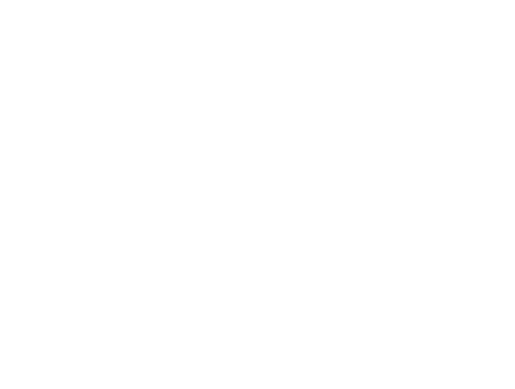

In [9]:
vars = {"AG.LND.FRST.ZS":"Deforestation"}

use=["BRA","ECU","VEN","COL","PER"]

deforestation = wbdata.get_dataframe(vars,country=use,parse_dates=True).squeeze().unstack('country')

deforestation = deforestation.loc["1990":]

plot = deforestation.plot(title="Deforestation Over the Years", labels={"index": "Year", "value": "Country's Forest (%)"})
plot.show()
deforestation.head()

## [C] Population Pyramid

## [C] Agriculture Supply